In [8]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [9]:
data_transforms = {
    "train" : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.255])
    ]),
    "val" : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.255])
    ])
}

In [10]:
data_dir = "../data/hymenoptera_data/"
image_datasets = {x : datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ["train", "val"]}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes  = {x : len(image_datasets[x]) for x in ["train", "val"]}

class_names = image_datasets["train"].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Visualize

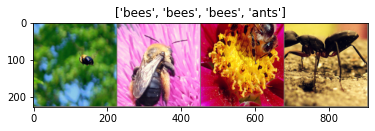

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Training the model


In [25]:
def train_model(model, criterion, optimizer, scheduler,num_epochs = 25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print("-"*20)
        
        for phase in ["train", "val"]:
            if phase  == "train":
                model.train()
            if phase == "val":
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs,labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
        
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                         
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == "train":
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print("{} Loss : {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        
        time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
        

In [39]:
def visualize_model(model, num_images = 6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Finetuning the convnet


In [27]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)
criterion= nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr = 0.001,momentum= 0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 7, gamma =0.1)

### Train and evaluate

In [28]:
model_ft = train_model(model=model_ft, criterion=criterion, optimizer= optimizer_ft,
                      scheduler= exp_lr_scheduler, 
                       num_epochs=5)

Epoch 0/4
--------------------
train Loss : 0.5209 Acc: 0.7295
val Loss : 0.1989 Acc: 0.9216
Epoch 1/4
--------------------
train Loss : 0.5580 Acc: 0.7500
val Loss : 0.2687 Acc: 0.8954
Epoch 2/4
--------------------
train Loss : 0.6421 Acc: 0.7459
val Loss : 0.4464 Acc: 0.8431
Epoch 3/4
--------------------
train Loss : 0.4416 Acc: 0.8402
val Loss : 0.2814 Acc: 0.8889
Epoch 4/4
--------------------
train Loss : 0.4917 Acc: 0.8033
val Loss : 0.4570 Acc: 0.8301
Training complete in 3m 27s
Best val Acc: 0.921569


## ConvNet as fixed feature extractor

In [31]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))
model_conv = model_conv.to(device)
critetrion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(),
                          lr = 0.001, momentum = 0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size = 7, gamma= 0.1)

In [32]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
--------------------
train Loss : 0.6303 Acc: 0.6516
val Loss : 0.2886 Acc: 0.8562
Epoch 1/24
--------------------
train Loss : 0.4899 Acc: 0.7705
val Loss : 0.2101 Acc: 0.9346
Epoch 2/24
--------------------
train Loss : 0.4019 Acc: 0.8074
val Loss : 0.1987 Acc: 0.9412
Epoch 3/24
--------------------
train Loss : 0.4508 Acc: 0.8033
val Loss : 0.3073 Acc: 0.8758
Epoch 4/24
--------------------
train Loss : 0.3677 Acc: 0.8238
val Loss : 0.2085 Acc: 0.9477
Epoch 5/24
--------------------
train Loss : 0.4057 Acc: 0.8115
val Loss : 0.2120 Acc: 0.9150
Epoch 6/24
--------------------
train Loss : 0.4746 Acc: 0.8033
val Loss : 0.2203 Acc: 0.9216
Epoch 7/24
--------------------
train Loss : 0.3835 Acc: 0.8320
val Loss : 0.2260 Acc: 0.9346
Epoch 8/24
--------------------
train Loss : 0.3169 Acc: 0.8648
val Loss : 0.2029 Acc: 0.9346
Epoch 9/24
--------------------
train Loss : 0.2730 Acc: 0.8525
val Loss : 0.2337 Acc: 0.9281
Epoch 10/24
--------------------
train Loss : 0.3250 Acc: 0.

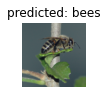

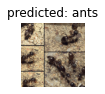

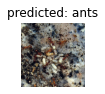

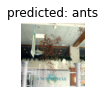

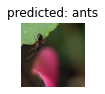

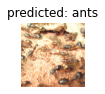

In [40]:
visualize_model(model_ft)